# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)



Using device: cpu


In [4]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [32]:
def calculate_averages_and_dispersion(data, data_percentage):
    df = data
    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [ ]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as and input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    # 1s window_size 100/27s = 3.7% of the data is used for each window
    df_window = calculate_averages_and_dispersion(df, data_percentage) 

    # Add a unique identifier column to avoid duplicate entries in the index
    df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

    # Pivot the DataFrame to wide format
    df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

    # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
    # df_pivot.columns = [' '.join(map(str, col)) for col in df_pivot.columns]
    df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]


    # Drop columns with all NaN values
    df_pivot = df_pivot.dropna(axis=1, how='all')

    # Reset index to make 'Sample' and 'unique_id' columns again
    df_pivot = df_pivot.reset_index()

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    # Remove 'unique_id' column
    df_pivot = df_pivot.drop(columns=['unique_id'])

    return df_pivot

In [227]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test/'
df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,-7.080942,-0.854611,A1
1,100.0,67.024785,0.244141,A1
2,100.0,124.893178,-1.098776,A1
3,100.0,91.075571,0.000000,A1
4,100.0,48.956174,0.122094,A1


## Sample a test set

In [253]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.2
train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

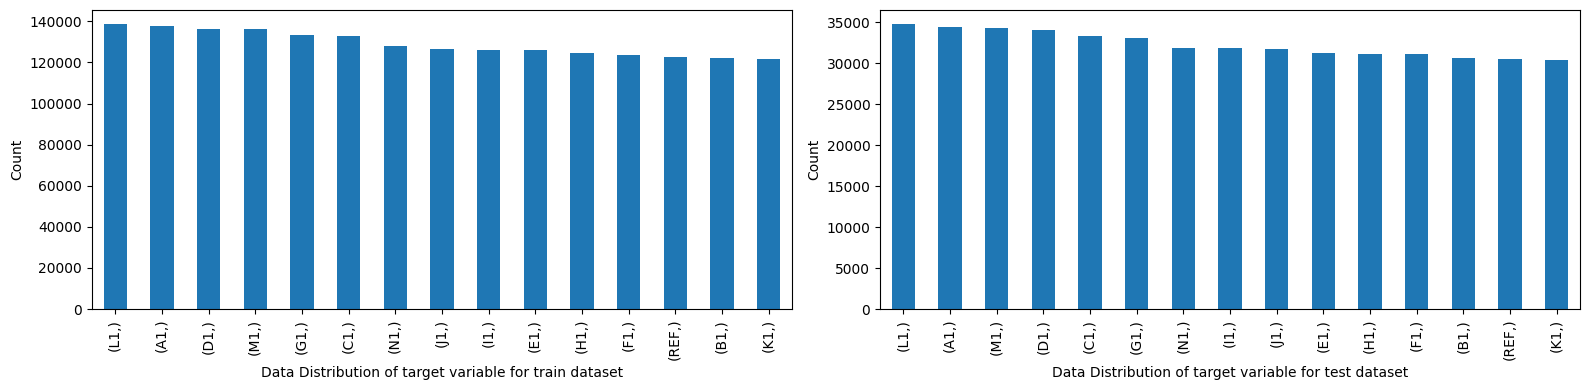

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [159]:
train_ex = train_set.copy()

In [160]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1936500 entries, 1587912 to 2219110
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Frequency (GHz)  float64
 1   LG (mV)          float64
 2   HG (mV)          float64
 3   Sample           object 
dtypes: float64(3), object(1)
memory usage: 73.9+ MB


In [167]:
train_ex['Sample'].nunique()
train_ex['Frequency (GHz)'].value_counts().sort_index().index

Index([100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0,
       200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0,
       300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0,
       400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0,
       500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0,
       600.0],
      dtype='float64', name='Frequency (GHz)')

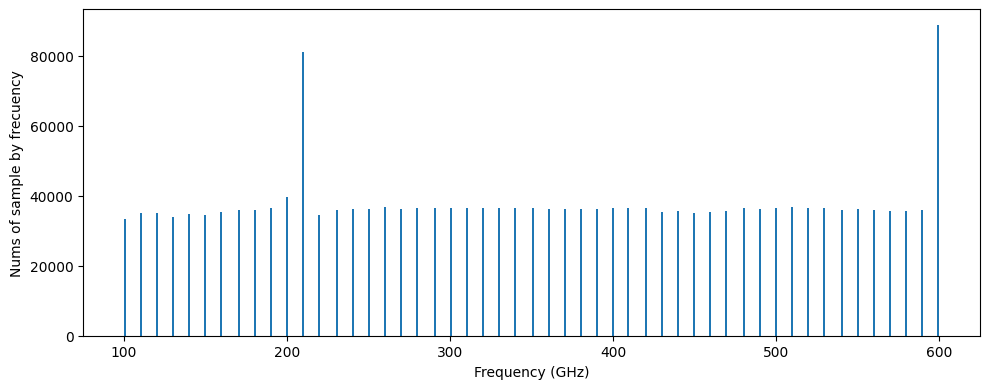

In [169]:
ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [309]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s
print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage = data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage = data_percentage_test)
# train_set_test.head()
# test_set_test.head()

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file
output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

train_set_test.to_csv(output_path, sep = ';', index=False)
test_set_test.to_csv(output_path_test, sep = ';', index=False)



Data percentage: 0.462962962962963%
Data percentage test: 1.851851851851852%


## Login in Weights & Biases

In [26]:
###
### SKIP FOR NOW ###
###

%env WANDB_API_KEY=94b4debef3cc9601df4d91995649548f8ab3a097
wandb.login()

# wandb.init(project='PIC-PAPER-01', entity='UC3M', name='RandomForest')
# wandb.watch(rf_model)

env: WANDB_API_KEY=94b4debef3cc9601df4d91995649548f8ab3a097


True

# Prepare Training Data
## Split the data into X and y


In [395]:
# Split the data into X and y
X_train = train_set_test.drop(columns=['Sample'])
y_train = train_set_test['Sample']

X_test = test_set_test.drop(columns=['Sample'])
y_test = test_set_test['Sample']

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)


labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']

# Reduce number of different samples for testing
# X_train = X_train[]




# le is the fitted LabelEncoder - Saving Encoder
# joblib.dump(le, 'label_encoder.pkl')

# Reduce the number of input features
freq = 360
num_freqs = 1
freq_col = int(((freq - 100)*4)/10)
freq_col_end = freq_col + 4 * num_freqs

X_train = X_train.iloc[:, freq_col:freq_col_end]
X_test = X_test.iloc[:, freq_col:freq_col_end]

# Eliminate std devt columns
X_train = X_train.iloc[:, ::2]
X_test = X_test.iloc[:, ::2]

print(X_test) #HG mean, HG std dev, LG mean, LG std dev

     360.0 HG (mV) mean  360.0 LG (mV) mean
0            674.920349            0.876794
1            663.044796            0.932287
2            674.309939            0.765807
3            672.112404            1.254148
4            680.891441            0.810202
..                  ...                 ...
911            2.330711            1.143162
912            2.752443            1.476121
913            2.375100            1.154260
914            3.163114            1.476121
915            3.784641            1.243049

[813 rows x 2 columns]


In [311]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

### Random Forest Model

In [312]:
def random_forest_model(X_train, y_train, seed):
    # Define Random Forest model
    rf_model = RandomForestClassifier(n_estimators=10, criterion='gini', random_state=seed)
    # Train the model
    rf_model.fit(X_train, y_train)
    return rf_model

### Define Naive-Bayes model


In [313]:
def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

### Logistic Regression

In [314]:
def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

Accuracy: 0.8105781057810578
Precision: 0.8101475222042162
Recall: 0.8105781057810578
F1: 0.80635437131808
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.83      1.00      0.91        54
           2       0.74      0.85      0.79        54
           3       1.00      1.00      1.00        54
           4       0.96      0.96      0.96        54
           5       0.85      0.65      0.74        54
           6       0.84      0.93      0.88        55
           7       0.54      0.52      0.53        54
           8       0.62      0.53      0.57        55
           9       0.66      0.80      0.72        54
          10       0.80      0.76      0.78        54
          11       0.73      0.69      0.70        54
          12       0.79      0.57      0.67        54
          13       0.80      0.91      0.85        54
          14       1.00      1.00      1.00        55

    accuracy               

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 0, 'Importance')

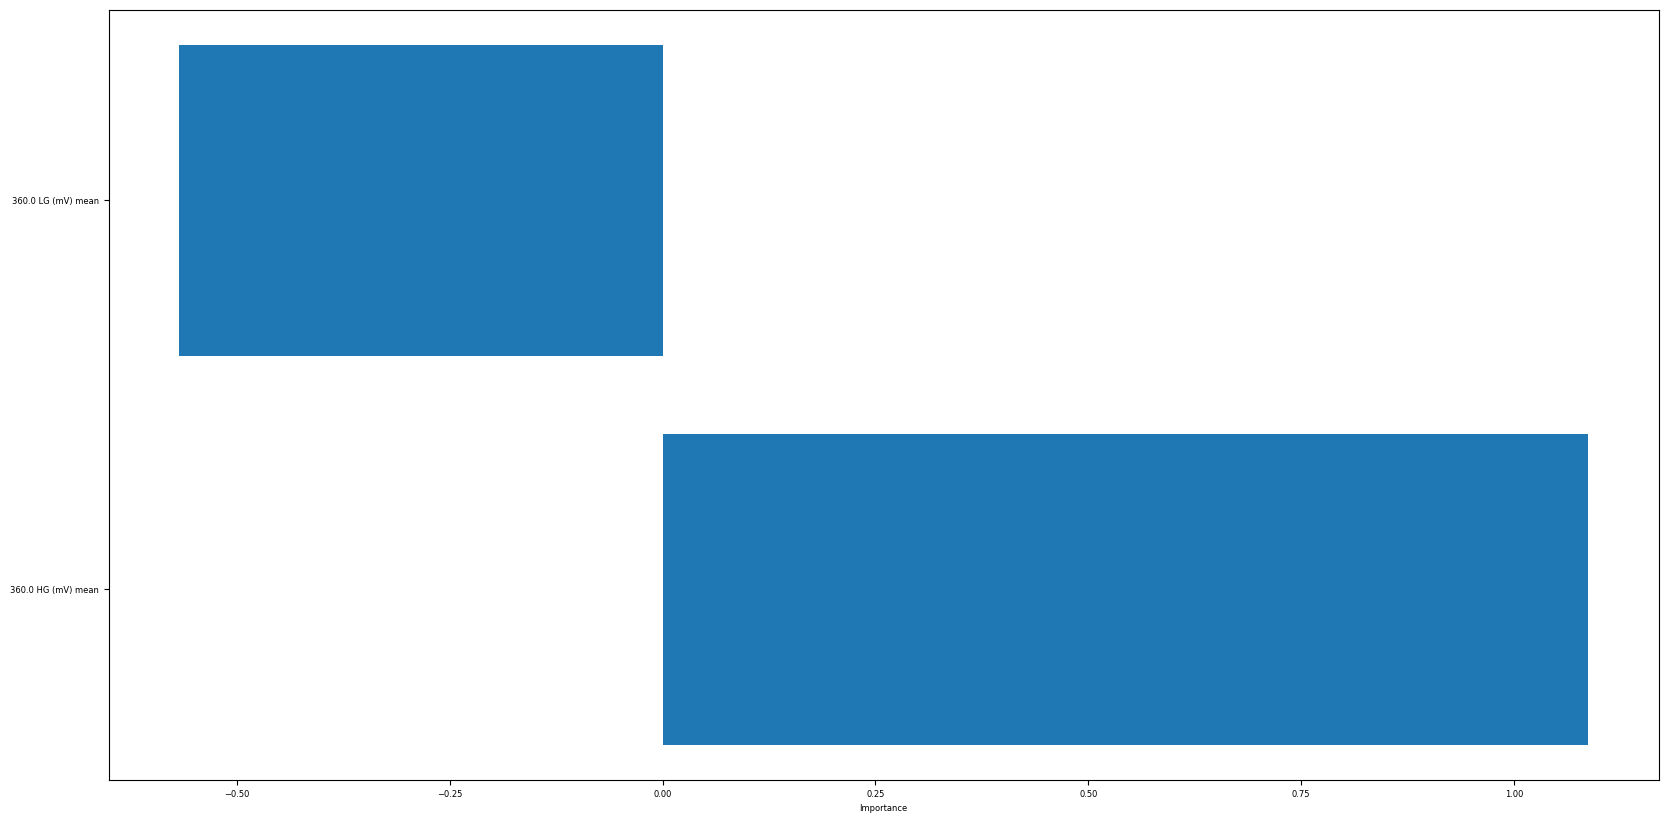

In [396]:
# Train models
rf_model = random_forest_model(X_train, y_train, seed)
# nb_model = naive_bayes_model(X_train, y_train)
lr_model = logistic_regression_model(X_train, y_train, seed)

# Predictions
# y_pred = rf_model.predict(X_test)
# y_pred = nb_model.predict(X_test)
y_pred = lr_model.predict(X_test)

# Save the model
# joblib.dump(rf_model, 'random_forest_model.pkl')
# joblib.dump(nb_model, 'naive_bayes_model.pkl')
# joblib.dump(lr_model, 'logistic_regression_model.pkl')

# # Create a DataFrame to compare
# df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(df_comparison.head(10))

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Classification report
print(classification_report(y_test, y_pred),)

# Predictions made per class with its label encoded value
print(Counter(y_pred))

# Feature importance (Find 10 most important variables with its name and importance value)
# feature_importances = rf_model.feature_importances_
feature_importances = lr_model.coef_[0]

feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
# Font size
plt.rcParams.update({'font.size': 6})
print(feature_importances_df.head(50))
plt.figure(figsize=(20, 10))
plt.barh(feature_importances_df['Feature'][:50], feature_importances_df['Importance'][:50])
plt.xlabel('Importance')


## Confusion Matrix

In [399]:
# # Confusion matrix with matplotlib

def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    plt.show()

# Call the function with appropriate arguments
labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']


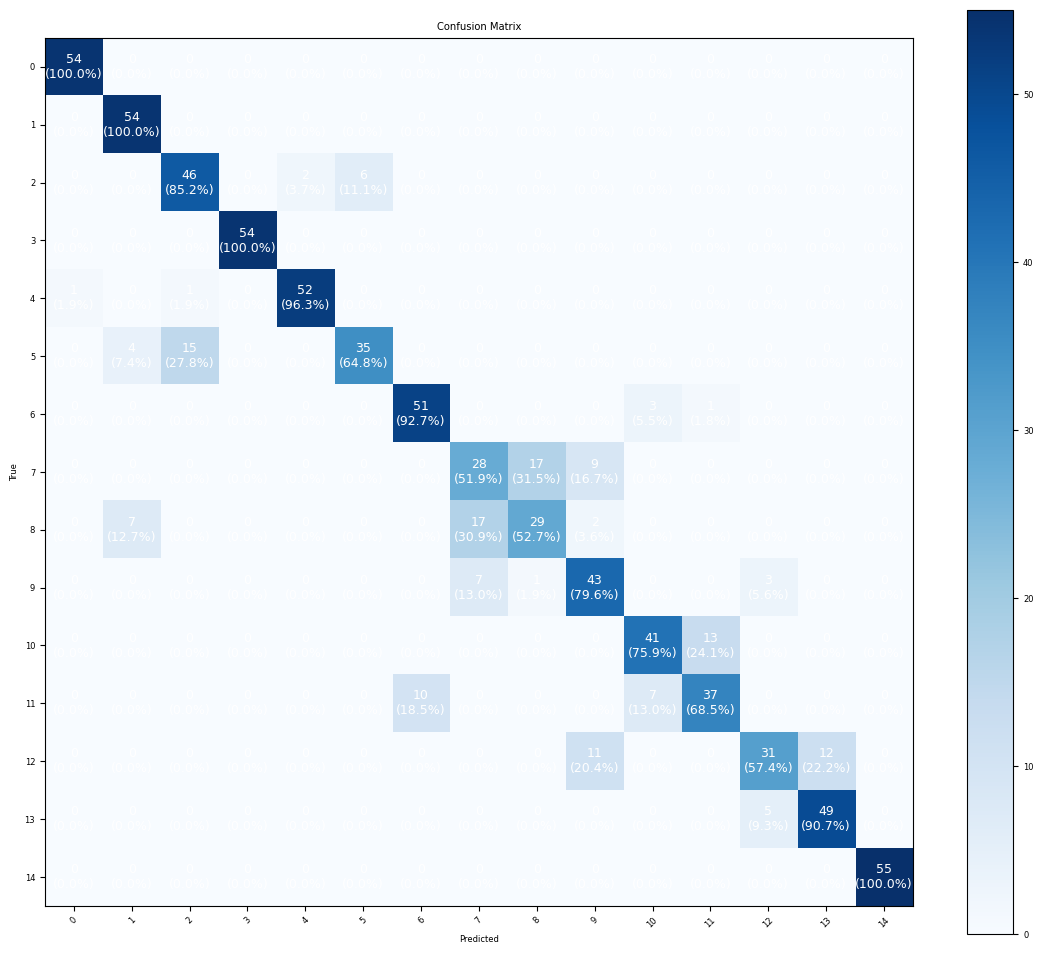

In [400]:
plot_confusion_matrix(y_test, y_pred, np.unique(y_test))

## Load and preprocess Other Test Data (Experiment 2)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [383]:
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

# Add .0 on every Frequency column value to match the format of the training data
df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'
print('X_new_sample:', df_new_sample)

# Time window
time_window_s = 0.1
sample_time_s = 12
data_percentage = (100/sample_time_s)*time_window_s
print(f"Data percentage: {data_percentage}%")

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage = data_percentage) # 0.22

df_new_sample = df_new_sample.dropna()

X_new_sample = df_new_sample.drop(columns=['Sample'])
y_new_sample = df_new_sample['Sample']

if y_new_sample.dtype == 'object':
    y_new_sample = le.transform(y_new_sample)

# Number of samples
num_samples = len(y_new_sample)



# # Reduce the number of input features
# freq = 300
# num_freqs = 5
# freq_col = int(((freq - 100)*4)/10)
# freq_col_end = freq_col + 4 * num_freqs

# X_train = X_train.iloc[:, freq_col:freq_col_end]
# X_test = X_test.iloc[:, freq_col:freq_col_end]

# Eliminate std devt columns
# X_new_sample = X_new_sample.iloc[:, ::2]
X_new_sample.head()


X_new_sample:       Frequency (GHz)   LG (mV)    HG (mV) Sample
0               100.0  0.000000  15.138566     H1
1               100.0 -1.098767  38.701013     H1
2               100.0  0.366256  37.358075     H1
3               100.0  0.488341  28.079599     H1
4               100.0  1.220852  46.880722     H1
...               ...       ...        ...    ...
73553           600.0  1.465023  38.456842     H1
73554           600.0 -1.953363  20.144060     H1
73555           600.0  0.244170  28.201684     H1
73556           600.0  0.610426  18.312782     H1
73557           600.0 -0.244170  30.521303     H1

[73558 rows x 4 columns]
Data percentage: 0.8333333333333335%


,100.0 HG (mV) mean,100.0 HG (mV) std deviation,100.0 LG (mV) mean,100.0 LG (mV) std deviation,110.0 HG (mV) mean,110.0 HG (mV) std deviation,110.0 LG (mV) mean,110.0 LG (mV) std deviation,120.0 HG (mV) mean,120.0 HG (mV) std deviation,...,580.0 LG (mV) mean,580.0 LG (mV) std deviation,590.0 HG (mV) mean,590.0 HG (mV) std deviation,590.0 LG (mV) mean,590.0 LG (mV) std deviation,600.0 HG (mV) mean,600.0 HG (mV) std deviation,600.0 LG (mV) mean,600.0 LG (mV) std deviation
0,32.631633,10.726077,0.034882,0.758221,-0.199762,0.712446,57.835096,17.068552,0.332960,0.950528,...,-0.396777,0.945847,46.290643,13.629955,0.172954,0.923131,30.277133,10.447527,-0.110987,0.671923
1,33.433908,13.417054,-0.174407,0.988958,-0.332956,1.005387,61.308975,14.741487,0.066590,0.892741,...,0.142433,0.512264,46.260122,10.509836,0.274692,0.686930,24.683411,8.664579,0.310762,0.731215
2,29.823674,12.371177,0.034882,0.988599,0.055493,0.576153,49.300229,11.567317,-0.210873,0.991972,...,0.518862,1.047795,41.478451,9.050209,0.010174,0.989717,24.539128,12.941608,0.288565,0.507125
3,32.090970,7.839933,0.680189,0.896744,-0.310742,0.570964,59.855051,14.986087,0.221963,0.612419,...,-0.050869,1.078803,42.516176,8.764374,-0.478167,1.064898,30.798770,7.705713,0.421749,0.950955
4,33.852485,10.972446,0.279052,0.609262,-0.011108,0.461522,59.211329,12.948172,-0.388449,0.597636,...,0.111911,0.623512,47.053676,11.293012,0.162780,0.817040,26.215025,10.875331,0.266368,0.988541


In [391]:
# y_pred = rf_model.predict(X_new_sample)
# y_pred = nb_model.predict(X_new_sample)
y_pred = lr_model.predict(X_new_sample)

# Calculate metrics
accuracy = accuracy_score(y_new_sample, y_pred)
precision = precision_score(y_new_sample, y_pred, average='weighted')
recall = recall_score(y_new_sample, y_pred, average='weighted')
f1 = f1_score(y_new_sample, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Classification report
print(classification_report(y_new_sample, y_pred), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

# plot_confusion_matrix(y_new_sample, y_pred, np.unique(y_new_sample))

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1: 0.0
              precision    recall  f1-score   support

           7       0.00      0.00      0.00     120.0
          13       0.00      0.00      0.00       0.0

    accuracy                           0.00     120.0
   macro avg       0.00      0.00      0.00     120.0
weighted avg       0.00      0.00      0.00     120.0

Counter({13: 120})


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
# Load trained model
rf_model = joblib.load('random_forest_model.pkl')

# Predictions
y_pred = rf_model.predict(X_new_sample)



## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |